# Project Three:  Data Mining for Personal Information from Anonymous Users

This is the initial or "core" Jupyter notebook in which the initial process of scraping, EDA, and model selection was performed.  A broad number of gridsearches were conducted to examine the relative efficacies on the data.

---

### Imports, function definitions, and data structures

In [2]:
#core imports
import numpy as np
import pandas as pd
import requests
import time

#Set-up and processing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

#Estimators and transformers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC

In [216]:
def get_pd(subreddit, category, content):
    #This function attempts to pull 4800 entries (100 for each day for the last 1-49 days) from Reddit given three parameters:
    #Subreddit:  Which subreddit the entries should be pulled from;
    #Category:  Whether the entries should be a "comment" or "submission";
    #Content:  The body-of-text word associated with a category ("selftext" for submissions, "body" for comments)
    url = f"https://api.pushshift.io/reddit/search/{category}"
    
    params = {
        "subreddit":subreddit,
        "size":"500",
        "fields":[content,"subreddit"]
            }

    a = 0
    b = 1
    posts = []

    while b < 50:
        params["after"] = f"{b}d"
        params["before"] = f"{a}d"
        res = requests.get(url, params)
        data = res.json()
        posts+= data["data"]
        a+=1
        b+=1
        time.sleep(3)

    return pd.DataFrame(posts)



def clean(df):
    #This function, specific to this notebook, performs some processing on the dataframes.
    df["subreddit"] = df["subreddit"].map({"nyc":0, "boston":1})
    df.rename(columns={"subreddit":"boston"}, inplace=True)
    df.dropna(inplace=True)

In [217]:
#Initial data scrapes + basic assessments of what was scraped.

snyc = get_pd("nyc", "submission", "selftext")
sbos = get_pd("boston", "submission", "selftext")
cnyc = get_pd("nyc", "comment", "body")
cbos = get_pd("boston", "comment", "body")

print(snyc.shape, sbos.shape)
print(cnyc.shape, cbos.shape)

(3646, 2) (2418, 2)
(4800, 2) (4800, 2)


### Acquiring three different dataframes and saving them to a csv file so data doesn't need to be scraped each time
There were some unexpected problems; namely, the `.replace()` method in pandas refuses to function properly if it is passed a pointer variable.  Both putting the code in a for loop and in the `clean(df)` function resulted in the replacements not working.  Therefore, it is performed manually in both this notebook and the next.

In [218]:
#Preparing the four dataframes to be concatenated
snyc.rename(columns={"selftext":"body"}, inplace=True)
sbos.rename(columns={"selftext":"body"}, inplace=True)

In [220]:
df = pd.concat([snyc, sbos, cnyc, cbos])
nyc = pd.concat([snyc, cnyc])
bos = pd.concat([sbos, cbos])
print(df.shape, nyc.shape, bos.shape)

(15664, 2) (8446, 2) (7218, 2)


In [221]:
clean(df)
clean(bos)
clean(nyc)

print(df.shape, nyc.shape, bos.shape)

(15664, 2) (8446, 2) (7218, 2)


In [239]:
#Replacements for removing removed comments, or deleted/empty submission selftexts, in addition to assessment of final shape.
df = df.replace("", np.nan)
df = df.replace("[removed]",np.nan)
df = df.replace("[deleted]",np.nan)
df.dropna(inplace=True)

nyc = nyc.replace("", np.nan)
nyc = nyc.replace("[removed]",np.nan)
nyc = nyc.replace("[deleted]",np.nan)
nyc.dropna(inplace=True)

bos = bos.replace("", np.nan)
bos = bos.replace("[removed]",np.nan)    
bos = bos.replace("[deleted]",np.nan)    
bos.dropna(inplace=True)

print(df.shape, nyc.shape, bos.shape)

(11244, 2) (5751, 2) (5493, 2)


In [240]:
df.to_csv("./data_core/df.csv", index=False)
nyc.to_csv("./data_core/nyc.csv", index=False)
bos.to_csv("./data_core/bos.csv", index=False)

In [238]:
#From here on out, if the dataframe becomes damaged, we need only to run this cell again rather than pull data from reddit all over again.
df = pd.read_csv("./data_core/df.csv")
nyc = pd.read_csv("./data_core/nyc.csv")
bos = pd.read_csv("./data_core/bos.csv")

---

## Additional Information

Here, I explored some graphs of most common words, but even after removing stop words & compiling a more extensive stop word list, none of the common words revealed anything particularly insightful about the two subreddits.  At this point in time, I was still struggling to come up with a problem statement, and considered this avenue of approach to mostly be a dead end - after all, the models were not highly accurate to begin with.  Therefore, I did not explore coefficients or word commonalities as a fruitful method of research.  This is possibly an area that could have benefited significantly from stemming or lemmatization (see Section 4: Results & Conclusions in the README for additional information).

In [245]:
#Extra stop words were compiled through successive iterations of running the graphs and dropping common words.  However, it didn't seem to get me anywhere.
stop_core = list(CountVectorizer(stop_words = 'english').get_stop_words())
city_names = ["boston", "Boston", "nyc", "NYC", "new", "New", "york", "York", "city", "City", "just", "like", "https", "know", "need", "say" ,"did", "ve", 
              "got", "don", "www", "ll", "com"]
super_stop = stop_core + city_names

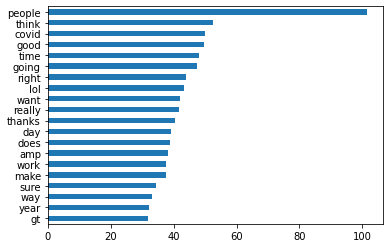

In [246]:
temp = pd.read_csv("./data_core/nyc.csv")
tvec = TfidfVectorizer(stop_words=super_stop)


# convert training data to dataframe
temp = pd.DataFrame(tvec.fit_transform(temp["body"]).todense(), 
                          columns=tvec.get_feature_names())

# plot top occuring words
temp.sum().sort_values().tail(20).plot(kind='barh');

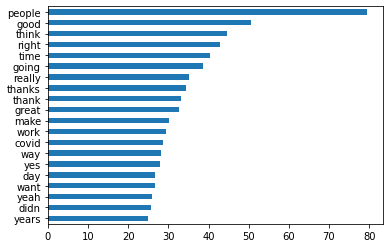

In [248]:
temp = pd.read_csv("./data_loc/bos.csv")
tvec = TfidfVectorizer(stop_words=super_stop)


# convert training data to dataframe
temp = pd.DataFrame(tvec.fit_transform(temp["body"]).todense(), 
                          columns=tvec.get_feature_names())

# plot top occuring words
temp.sum().sort_values().tail(20).plot(kind='barh');

---

# Modelling Exploration

This section was dedicated to some initial explorations of NLP preprocessing & modelling, prior to running a set of pipelines & gridsearches to find the best model.  This allowed me to make sure I had a firm grasp on the preprocessing & modelling process before proceeding to the final step and selecting a model for my problem statement.

In [250]:
X = df["body"]
y = df["boston"]

### Vectorizer exploration
This was just to be sure that CountVectorizer was working as intended before pipelining it.

In [251]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)

cvec = CountVectorizer()
cvec.fit(X_train)
X_train = cvec.transform(X_train)
X_test = cvec.transform(X_test)

print(X_train.shape, X_test.shape)

(8995,)
(8995, 20277) (2249, 20277)


### Naive Bayes initial

Initial exploration of Naive Bayes to see what the model's baseline is going to look like before a proper gridsearch.

Despite this being the first model that I ran, and with little to no exploration of hyperparameters beyond the default, this model performed the best out of everything I tested.  

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pipe_nb = Pipeline([
    ("cvec", CountVectorizer()),
    ("nb", MultinomialNB())
])


print(f"Initial evaluation:\t{cross_val_score(pipe_nb, X_train, y_train, cv=3).mean()}")

pipe_nb.fit(X_train, y_train)

print(f"Training score:\t\t{pipe_nb.score(X_train, y_train)}")
print(f"Test score:\t\t{pipe_nb.score(X_test, y_test)}")

Initial evaluation:	0.6767093367346598
Training score:		0.8591439688715953
Test score:		0.6878612716763006


### K-Nearest Neighbors initial

Initial exploration of KNN to see what the model's baseline is going to look like before a proper gridsearch.

As expected, KNN did very terribly, as expected, since it scales poorly to datasets that are large; this dataset was some 8,000 rows by 20,000 columns.

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pipe_knn = Pipeline([
    ("cvec", CountVectorizer()),
    ("knn", KNeighborsRegressor())
])


print(f"Initial evaluation:\t{cross_val_score(pipe_knn, X_train, y_train, cv=3).mean()}")

pipe_knn.fit(X_train, y_train)

print(f"Training score:\t\t{pipe_knn.score(X_train, y_train)}")
print(f"Test score:\t\t{pipe_knn.score(X_test, y_test)}")

Initial evaluation:	-0.14861544169059168
Training score:		0.23465267077650473
Test score:		-0.1530815664091425


---

# Gridsearching for the best model

For models were gridsearched in order to find the best configuration of hyperparameters & model that could least to the best predictive ability.  Some of these cells were run several times with different parameter sets (if so, there are some additional notes).  There exists some inconsistency between use of CountVectorizer and TfidfVectorizer; this occured in cells where multiple gridsearches were run.  Different vectorizers were fed into the pipeline to ascertain whether they had an effect on outcome.  However, the models did not significantly change their output regardless of which vectorizer was used.

---

### Model: Naive Bayes

Because this performed the best out of all models, the hyperparameters of this model were the most extensively explored.  Each iteration of GridSearch took 1-5 minutes to run and a total of 3-6 gridsearches were performed.  The cell outputs below are the result of the latest iteration of gridsearches; as you can see, the result was much worse than the initial parameters best yield & the ungridsearched initial exploration above.  For comparison, the best results of all gridsearches is listed, which turned out to be the first gridsearch.

| Model: Naive Bayes | Value              |
|--------------------|--------------------|
| Best Score         | 0.6658143413007226 |
| Training Score     | 0.7607559755419677 |
| Testing Score      | 0.6696309470875945 |
| Max DF             | 0.9                |
| Max Features       | 5000               |
| Min DF             | 1                  |
| Ngram Range        | (1, 1)             |
| Stop Words         | "english"          |

In [298]:
pipe_nb = Pipeline([
    ("tvec", TfidfVectorizer(stop_words="english")),
    ("nb", MultinomialNB())
])


nb_params = {
    "tvec__max_features": [8_000, 9_000, 10_000],
    "tvec__min_df": [1],
    "tvec__max_df": np.linspace(.3, .5, 5),
    "tvec__ngram_range": [(1,1)],
    "nb__alpha": np.logspace(5, 50, 10)
}

In [299]:
%%time

gs_nb = GridSearchCV(
    pipe_nb,
    param_grid=nb_params,
    cv=5,
    n_jobs=16
)

gs_nb.fit(X_train, y_train)

CPU times: user 3.82 s, sys: 174 ms, total: 4 s
Wall time: 56.6 s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [300]:
print(f"Best score:\t{gs_nb.best_score_}")
print(f"Train score:\t{gs_nb.score(X_train, y_train)}")
print(f"Test score:\t{gs_nb.score(X_test, y_test)}")

for param, val in gs_nb.best_params_.items():
    print(f"{param[6:]}:  {val}")

Best score:	0.5129516397998888
Train score:	0.5129516397998888
Test score:	0.5055580257892397
pha:  100000.0
max_df:  0.3
max_features:  8000
min_df:  1
ngram_range:  (1, 1)


---

### Model: K-Nearest Neighbors

Out of all models, this far and away performed the worst.  It never even got close to the baseline (and instead was predicting negatively) so no additional gridsearches were performed after the initial.

In [257]:
pipe_params = {
    "cvec__max_features": [500, 1_000, 2_000, 5_000],
    "cvec__min_df": [1, 2, 3],
    "cvec__max_df": [.9, .95],
    "cvec__ngram_range": [(1,1), (1,2)],
    "cvec__stop_words": ["english"]
}

In [257]:
%%time





gs_knn = GridSearchCV(
    pipe_knn,
    param_grid=pipe_params,
    cv=5,
    n_jobs=16
)

gs_knn.fit(X_train, y_train)

CPU times: user 2.04 s, sys: 296 ms, total: 2.34 s
Wall time: 50.5 s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [258]:
print(f"Best score:\t{gs_knn.best_score_}")
print(f"Train score:\t{gs_knn.score(X_train, y_train)}")
print(f"Test score:\t{gs_knn.score(X_test, y_test)}")

for param, val in gs_knn.best_params_.items():
    print(f"{param[6:]}:  {val}")

Best score:	-0.08746631940275469
Train score:	0.26181486493425754
Test score:	-0.09125089374410811
max_df:  0.9
max_features:  5000
min_df:  2
ngram_range:  (1, 2)
stop_words:  english


---

### Model: Extra Trees

Extra Trees was used for the gridsearch because the model runs significantly faster than Random Forest.  I did some additional research on the differences between the two models and it seems that Extra Trees underperformed between 3-7% as compared to Random Forest.  Although this model performed noticably above the baseline, it did not reach levels such that I thought it might noticeably outperform Naive Bayes if I ran Random Forest instead.  Somewhat belatedly, I think that perhaps the hyperparameters (specifically, number of estimators & max depth) should have been explored a lot more, especially if the data has been lemmatized.  

In [265]:
pipe_et = Pipeline([
    ("cvec", CountVectorizer(stop_words="english")),
    ("et", ExtraTreesClassifier())
])


et_params = {
    "cvec__min_df": [2, 3],
    "cvec__max_df": [.9, .95],
    "cvec__ngram_range": [(1,1), (1,2)],
    "et__n_estimators": [50, 100],
    "et__max_features": [None, 'auto', 'log2'],
    "et__max_depth": [5, 6]
}

In [266]:
%%time

gs_et = GridSearchCV(
    pipe_et, 
    param_grid=et_params, 
    cv=5,
    n_jobs=16
)

gs_et.fit(X_train, y_train)

CPU times: user 5.01 s, sys: 135 ms, total: 5.14 s
Wall time: 2min 29s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [267]:
print(f"Best score:\t{gs_et.best_score_}")
print(f"Train score:\t{gs_et.score(X_train, y_train)}")
print(f"Test score:\t{gs_et.score(X_test, y_test)}")

for param, val in gs_et.best_params_.items():
    print(f"{param[6:]}:  {val}")

Best score:	0.58899388549194
Train score:	0.5927737632017788
Test score:	0.588706091596265
max_df:  0.9
min_df:  2
ngram_range:  (1, 1)
x_depth:  6
x_features:  None
estimators:  100


---

### Model: SVM

This was the only model that performed above the 60% accuracy barrier on the first run, so I spent a significant amount of time running different hyperparameter configurations in this gridsearch as well as in NB.  Unlike Naive Bayes, I was actually able to improve the original score (61%) to around 63%.  However, this is only a marginal increase and it still failed to outperform Bayes.  Below, the parameters for the original best score is provided, with the latest iteration (63%) in the cell output.

| Model: SVM         | Value              |
|--------------------|--------------------|
| Best Score         | 0.5989994441356309 |
| Training Score     | 0.8359088382434686 |
| Testing Score      | 0.6149399733214762 |
| Max DF             | 0.9                |
| Min DF             | 2                  |
| Ngram Range        | (1, 1)             |
| C                  | 1.8421052631578947 |
| Kernel             | "rbf"              |

In [281]:
pipe_svc = Pipeline([
    ("cvec", CountVectorizer(max_features=2_000, stop_words = "english")),
    ("svc", SVC())
])

svc_params = {
    "cvec__min_df": [1, 2],
    "cvec__max_df": np.linspace(0.1, 0.4, 6),
    "cvec__ngram_range": [(1,1)],
    "svc__C":[1.8],
    "svc__kernel":['rbf'],
}

In [282]:
%%time

gs_svc = GridSearchCV(
    pipe_svc, 
    param_grid=svc_params, 
    cv=5,
    n_jobs=16
)

gs_svc.fit(X_train, y_train)

CPU times: user 7.67 s, sys: 19.2 ms, total: 7.69 s
Wall time: 1min 47s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=2000,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [283]:
print(f"Best score:\t{gs_svc.best_score_}")
print(f"Train score:\t{gs_svc.score(X_train, y_train)}")
print(f"Test score:\t{gs_svc.score(X_test, y_test)}")

for param, val in gs_svc.best_params_.items():
    print(f"{param[6:]}:  {val}")

Best score:	0.626792662590328
Train score:	0.8385769872151195
Test score:	0.6345042240995998
max_df:  0.16000000000000003
min_df:  2
ngram_range:  (1, 1)
:  1.8
ernel:  rbf
